# Unstructured Data Analytics HW2

Name: Jhanvi Udani  

Andrew ID: judani

Human or AI collaborators (if none, say "none"; do not leave this blank): No human collaborators. Used GenAI for understanding and debugging code for the TFI-DF related questions. 

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [34]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [35]:
########################################################################
######################### Write your code here #########################
########################################################################
import os 

enron_dir = "data/enron"

documents = []

for filename in os.listdir(enron_dir):
    file_path = os.path.join(enron_dir, filename)
    if os.path.isfile(file_path):
        processed_doc = make_word_list(file_path)
        documents.append(processed_doc)

print(f"Processed {len(documents)} documents.")

Processed 5172 documents.


### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [36]:
########################################################################
######################### Write your code here #########################
########################################################################


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=50,
    stop_words="english",
    max_df=0.8
)

X = vectorizer.fit_transform(documents)

vocab = vectorizer.vocabulary_

print(f"Number of unique words in the vocabulary: {len(vocab)}")


Number of unique words in the vocabulary: 1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [37]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.mixture import GaussianMixture

X_dense = X.toarray()

gmm = GaussianMixture(n_components=3, random_state=42)

predicted_clusters = gmm.fit_predict(X_dense)

cluster_counts = [sum(predicted_clusters == i) for i in range(3)]

print("Number of documents per cluster:")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} documents")


Number of documents per cluster:
Cluster 0: 4350 documents
Cluster 1: 341 documents
Cluster 2: 481 documents


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [38]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

Spammy words and indices: [('click', 238), ('www', 1670), ('offer', 998)]
Hammy words and indices: [('meeting', 904), ('attached', 108), ('review', 1283)]


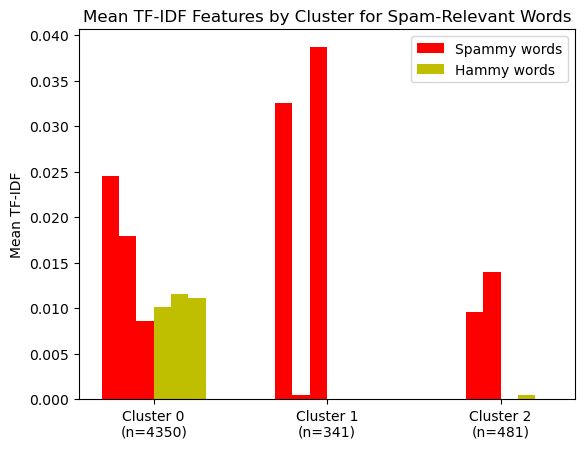

In [39]:
########################################################################
######################### Write your code here #########################
########################################################################

feature_names = vectorizer.get_feature_names_out()

spam_words = ['click', 'www', 'offer']
ham_words = ['meeting', 'attached', 'review']

spam_indices = [np.where(feature_names == word)[0][0] for word in spam_words]
ham_indices = [np.where(feature_names == word)[0][0] for word in ham_words]

print("Spammy words and indices:", list(zip(spam_words, spam_indices)))
print("Hammy words and indices:", list(zip(ham_words, ham_indices)))

plot_spam_words_by_cluster(X, predicted_clusters, n_clusters=3, 
                           spam_indices=spam_indices, ham_indices=ham_indices)



In [40]:
print(feature_names)


['aa' 'ability' 'able' ... 'yesterday' 'york' 'young']


##### Note: Used perplexity.ai to understand the requirement of this question and it gave me some code. After looking at that, I could write my own code with some changes. 

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***


#### Three-Cluster Model Results

- **Cluster 0** (4,350 documents): Shows a moderate presence of both spammy and hammy words. The yellow bars (hammy words) appear significant, suggesting this cluster contains legitimate business emails with some spam-like terms.

- **Cluster 1** (341 documents): Has very high red bars (spammy words) and virtually no yellow bars (hammy words). This strongly indicates a spam cluster - these 341 emails appear to be predominantly spam.

- **Cluster 2** (481 documents): Shows some spammy word presence but minimal hammy word presence. This appears to be another potential spam cluster, though not as pronounced as Cluster 1.

#### Two-Cluster Model Results (as run in the following code cell): 

Your second chart with 2 clusters shows:

- **Cluster 0** (4,561 documents): Contains both spammy and hammy words in a balanced distribution, suggesting these are primarily legitimate business emails.

- **Cluster 1** (611 documents): Shows very high spammy word frequency and minimal hammy word presence, strongly indicating this is a spam cluster.

#### Comparison of Models

The 2-cluster model appears to have more cleanly separated emails into:
1. A ham cluster (Cluster 0)
2. A spam cluster (Cluster 1)

The 3-cluster model split the data into:
1. A ham cluster (Cluster 0)
2. A very obvious spam cluster (Cluster 1)
3. A secondary, less obvious spam cluster (Cluster 2)

For spam detection purposes, the 2-cluster model appears more practical as it creates a cleaner separation between ham and spam. The 3-cluster model provides more granularity by identifying different "types" of spam, which might be useful for more nuanced analysis.

GMM clustering has successfully identified distinct email types based on word frequencies, with clear evidence of separation between spam and legitimate business correspondence.


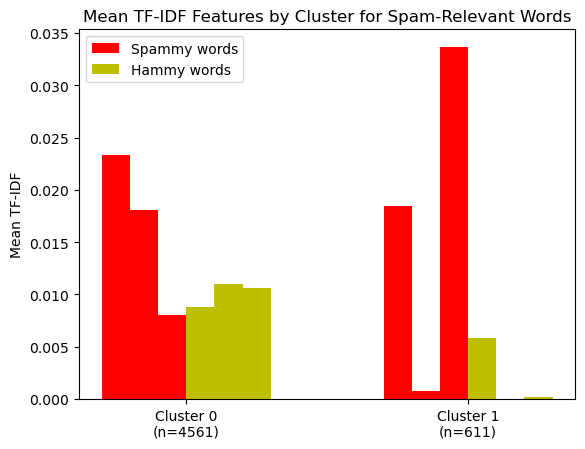

In [41]:
########################################################################
######################### Write your code here #########################
########################################################################

# For n_clusters=2
gmm = GaussianMixture(n_components=2, random_state=42)
predicted_clusters = gmm.fit_predict(X_dense)
plot_spam_words_by_cluster(X, predicted_clusters, n_clusters=2, 
                           spam_indices=spam_indices, ham_indices=ham_indices)


## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [43]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [44]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [45]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [46]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [47]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

print("TF-IDF transformation complete. Shape:", X_tfidf.shape)


TF-IDF transformation complete. Shape: (180295, 173)


### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [48]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=10,  
    max_iter=10,      
    n_jobs=-1,        
    random_state=42   
)

topic_document = lda.fit_transform(X_tfidf)

print("LDA model fitting complete!")
print(f"Topic-document matrix shape: {topic_document.shape}")


LDA model fitting complete!
Topic-document matrix shape: (180295, 10)
CPU times: user 2.1 s, sys: 501 ms, total: 2.6 s
Wall time: 13.1 s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [49]:
########################################################################
######################### Write your code here #########################
########################################################################

feature_names = permission_columns

top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-top_words-1:-1]
    
    print(f"Topic {topic_idx}:")
    for i, idx in enumerate(top_indices):
        print(f"    {i+1}. {feature_names[idx]} (weight: {topic[idx]:.4f})")
    print()


Topic 0:
    1. Services that cost you money : send SMS messages (D) (weight: 2256.2381)
    2. Hardware controls : record audio (D) (weight: 1904.2744)
    3. Your personal information : read contact data (D) (weight: 1468.6182)
    4. Your messages : receive SMS (D) (weight: 1408.1937)
    5. Phone calls : read phone state and identity (D) (weight: 1134.1606)
    6. Your messages : read SMS or MMS (D) (weight: 1124.5646)
    7. Phone calls : intercept outgoing calls (D) (weight: 1098.5517)
    8. Network communication : full Internet access (D) (weight: 1014.1104)
    9. System tools : automatically start at boot (S) (weight: 981.9601)
    10. Network communication : create Bluetooth connections (D) (weight: 961.6994)

Topic 1:
    1. Network communication : receive data from Internet (S) (weight: 2733.0457)
    2. Network communication : view network state (S) (weight: 937.6609)
    3. System tools : prevent device from sleeping (D) (weight: 829.5718)
    4. Hardware controls : cont

*** WRITE YOUR ANSWER HERE IN TEXT ***


Topic 0:
Dominated by permissions for sending/receiving SMS, recording audio, accessing contacts, and intercepting calls.  
**This topic is meaningful** because it clearly represents messaging and communication apps, which require these permissions.


Topic 1: 
Focuses on network communication, device wake locks, and location access, suggesting apps that run background services or sync data, possibly with location features.  
**This topic is somewhat meaningful** as it points to background service or utility apps, but is a bit broad and could include many app types.


Topic 2:
Emphasizes calendar and account access, with some device controls, indicating productivity or scheduling apps that manage events and user accounts.  
**This topic is meaningful** because it clearly corresponds to productivity or calendar apps.



Topic 3:
Strongly focused on fine and coarse location, camera, and network access, likely representing navigation, travel, or map-based apps.  
**This topic is meaningful** as the permissions are specific to navigation/location-based apps.

Topic 4: 
Highlights contact data, location, and network access, suggesting social networking or contact management apps that use location sharing.  
**This topic is meaningful** because it aligns well with social/contact apps.

Topic 5:
Dominated by phone state, network, and storage permissions, but lacks a clear app function; could be utilities or system apps.  
**This topic is not meaningful** as it is too generic and not tied to a specific app purpose.

Topic 6:
Centered on vibration control, auto-start, and network access, possibly representing notification, alarm, or background service apps.  
**This topic is somewhat meaningful**; it is interpretable but still broad and overlaps with other topics.

Topic 7: 
Strongly features wallpaper and system setting permissions, clearly indicating personalization or wallpaper apps.  
**This topic is meaningful** as it is clear and specific to personalization.

Topic 8: 
Focuses on preventing device sleep and UI changes, suggesting power management or screen utility apps.  
**This topic is somewhat meaningful**; it is interpretable but could include a variety of utility apps.

Topic 9:
Overwhelmingly dominated by generic internet and network permissions, with little else of note.  
**This topic is not meaningful** as it is too generic and does not correspond to a specific app purpose.


### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [50]:
########################################################################
######################### Write your code here #########################
########################################################################

popular_app_indices = np.where(app_ratings >= 100000)[0]

top_n = 3
for topic_idx in range(lda.n_components):
    topic_probs = topic_document[popular_app_indices, topic_idx]

    top_indices = topic_probs.argsort()[-top_n:][::-1]
    app_indices = popular_app_indices[top_indices]
    print(f"Topic {topic_idx}:")
    for i, idx in enumerate(app_indices):
        print(f"  {i+1}. {app_names[idx]} (Ratings: {app_ratings[idx]}, Topic prob: {topic_document[idx, topic_idx]:.4f})")
    print()



Topic 0:
  1. GO SMS Pro (Ratings: 130303, Topic prob: 0.8398)
  2. Handcent SMS (Ratings: 396166, Topic prob: 0.8125)
  3. Tango Voice & Video Calls (Ratings: 109238, Topic prob: 0.8087)

Topic 1:
  1. eBuddy Messenger (Ratings: 124973, Topic prob: 0.7423)
  2. Restaurant Story™ (Ratings: 109318, Topic prob: 0.7273)
  3. Restaurant Story??? (Ratings: 108088, Topic prob: 0.7273)

Topic 2:
  1. Tiny Flashlight + LED (Ratings: 600183, Topic prob: 0.7497)
  2. The Weather Channel (Ratings: 211337, Topic prob: 0.5546)
  3. Brightest Flashlight Free™ (Ratings: 139279, Topic prob: 0.5335)

Topic 3:
  1. Street View on Google Maps (Ratings: 168367, Topic prob: 0.6616)
  2. GasBuddy (Ratings: 242005, Topic prob: 0.5609)
  3. Toss It (Ratings: 160275, Topic prob: 0.5012)

Topic 4:
  1. KakaoTalk Mes???sen???ger (Ratings: 686446, Topic prob: 0.8025)
  2. KakaoTalk Mes​sen​ger (Ratings: 689648, Topic prob: 0.8025)
  3. Evernote (Ratings: 182863, Topic prob: 0.7950)

Topic 5:
  1. Angry Birds (Rat

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

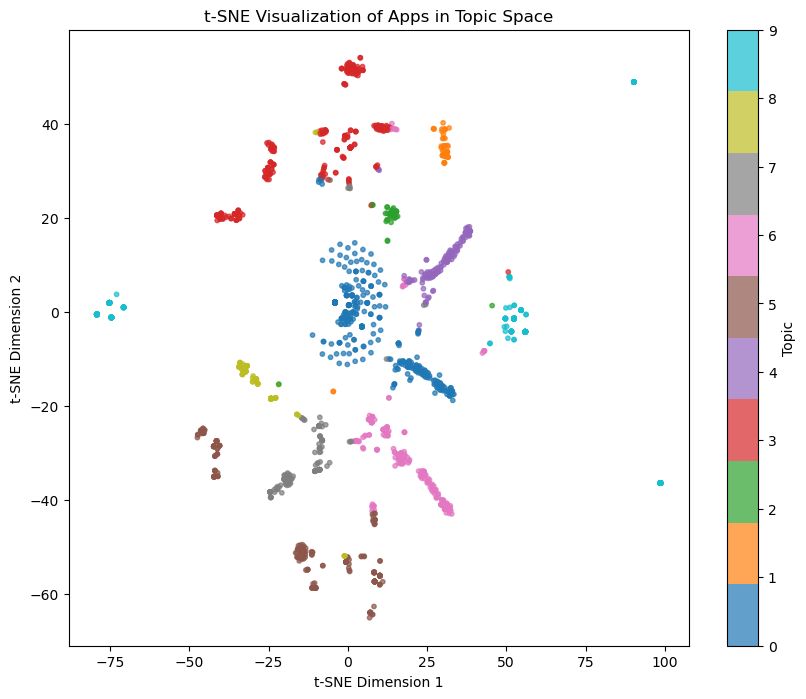

CPU times: user 5.44 s, sys: 174 ms, total: 5.61 s
Wall time: 3.62 s


In [51]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

sample_size = 2000
np.random.seed(42)
sample_indices = np.random.choice(topic_document.shape[0], sample_size, replace=False)
X_sample = topic_document[sample_indices]

tsne = TSNE(n_components=2, angle=0.99, init='pca', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

topic_labels = np.argmax(X_sample, axis=1)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=topic_labels, cmap='tab10', s=10, alpha=0.7)
plt.title("t-SNE Visualization of Apps in Topic Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, ticks=range(10), label='Topic')
plt.show()


## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/AShiHp2g4rnLeeqi7